In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio

In [24]:
#train sample locations
train_points_path = 'data/vector/train_points.geojson'
bird_points_path = 'data/vector/2019PointCounts.kml'
covertype_path = 'data/raster/terrain/covertype.tif'
lidar_path = 'data/raster/lidar_products/2019_lidar_cover.tif'

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_85641/2317073010.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  all_bird_points = bird_points.geometry.unary_union


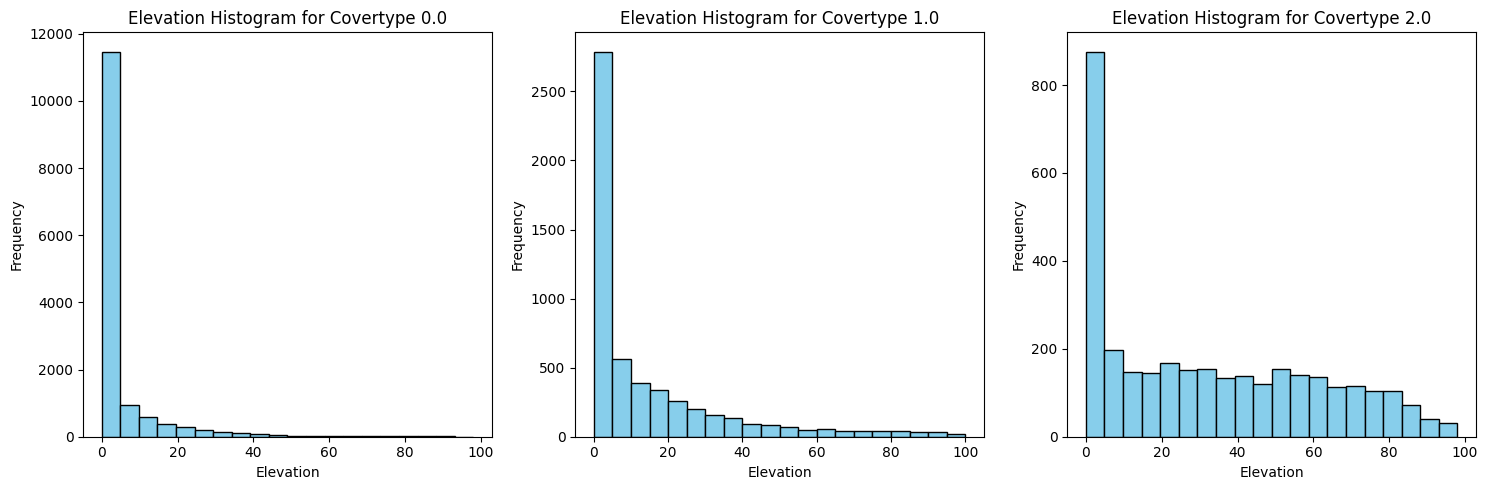

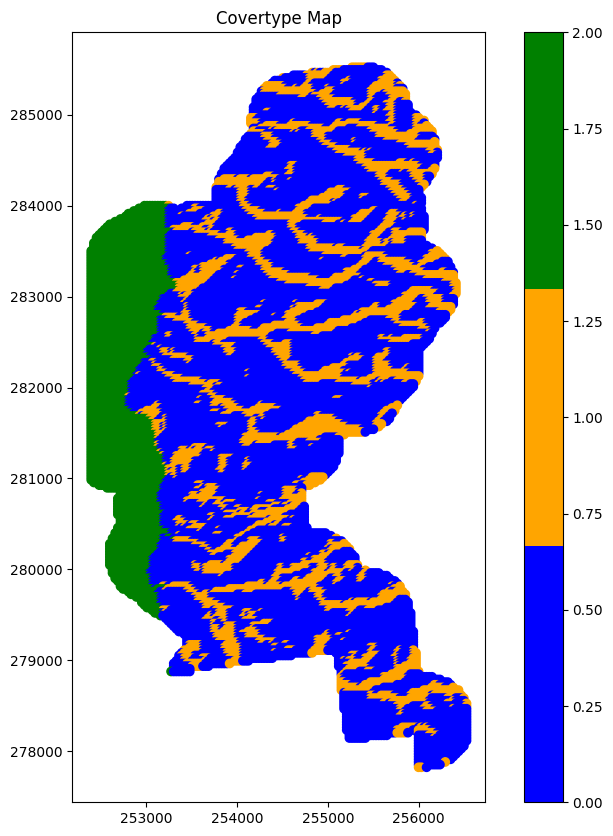

In [28]:
train_points = gpd.read_file(train_points_path)
bird_points = gpd.read_file(bird_points_path)
bird_points = bird_points.to_crs(train_points.crs)

# Load the covertype raster
covertype_raster = rasterio.open(covertype_path)
lidar_raster = rasterio.open(lidar_path)

# Extract covertype values at train point locations
def extract_covertype_and_lidar(point):
    try:
        return next(covertype_raster.sample([(point.x, point.y)]))[0], next(lidar_raster.sample([(point.x, point.y)]))[0]
    except:
        return None, None

train_points['covertype'], train_points['elevation'] = zip(*train_points.geometry.apply(extract_covertype_and_lidar))

# Create a MultiPoint object from all bird observation points
all_bird_points = bird_points.geometry.unary_union
buffer_dist = 500

# Create a buffer around the bird observation points
buffered_bird_points = all_bird_points.buffer(buffer_dist)

# Filter train points to only include those within the buffer
train_points = train_points[train_points.geometry.within(buffered_bird_points)]

# Get y-coordinates of all points
all_y = train_points.geometry.y

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

covertypes = train_points['covertype'].unique()
covertypes = sorted(covertypes[~pd.isnull(covertypes)]) #sort and remove nans

for i, covertype in enumerate(covertypes):
    # Filter points for the current covertype
    covertype_points = train_points[train_points['covertype'] == covertype]
    
    # Create a histogram of elevation values
    ax = axes[i]
    ax.hist(covertype_points['elevation'].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Elevation Histogram for Covertype {covertype}')
    ax.set_xlabel('Elevation')
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
colors = ['blue','orange','green']
custom_cmap = matplotlib.colors.ListedColormap(colors)
train_points.plot(column='covertype', legend=True, ax=ax, cmap=custom_cmap)
ax.set_title('Covertype Map')
plt.show()





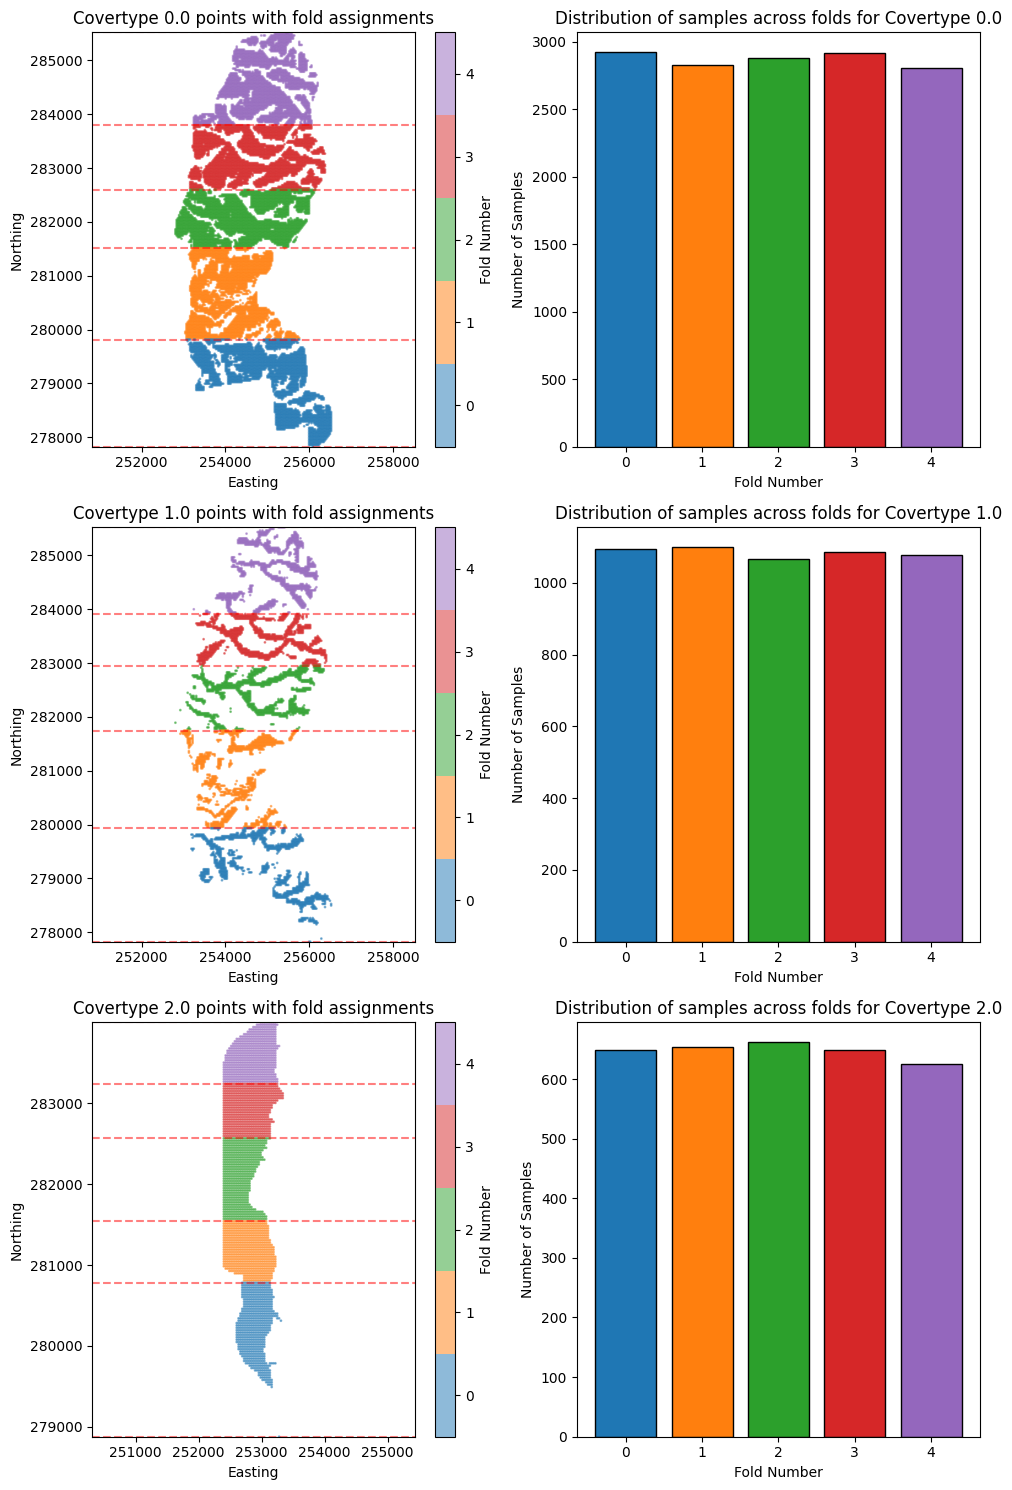

In [33]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten()

# Create a custom colormap with 5 distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5 distinct colors
custom_cmap = matplotlib.colors.ListedColormap(colors)

covertypes = train_points['covertype'].unique()
covertypes = sorted(covertypes[~pd.isnull(covertypes)]) #sort and remove nans

for i, covertype in enumerate(covertypes):
    # Filter points for the current covertype
    covertype_points = train_points[train_points['covertype'] == covertype].copy()
    
    # Get y-coordinates of all points for this covertype
    all_y = covertype_points.geometry.y
    
    # Create bands with equal number of points in each fold
    num_folds = 5
    y_bands = np.percentile(all_y, np.linspace(0, 100, num_folds + 1))
    
    # Assign folds based on which band each point falls into
    covertype_points.loc[:, 'fold'] = pd.cut(covertype_points.geometry.y, bins=y_bands, labels=False, include_lowest=True)
    
    # Update the original train_points with the fold assignments
    train_points.loc[covertype_points.index, 'fold'] = covertype_points['fold']
    
    # Plot all points with y_bands on first subplot
    ax1 = axes[i*2]
    
    # Calculate the range of x and y coordinates
    x_min, x_max = covertype_points.geometry.x.min(), covertype_points.geometry.x.max()
    y_min, y_max = covertype_points.geometry.y.min(), covertype_points.geometry.y.max()
    
    # Calculate the width and height of the plot
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    # Determine the plot size based on the larger range
    plot_range = max(x_range, y_range)
    
    # Set the plot limits to maintain a 1:1 aspect ratio
    ax1.set_xlim(x_min - (plot_range - x_range) / 2, x_max + (plot_range - x_range) / 2)
    ax1.set_ylim(y_min - (plot_range - y_range) / 2, y_max + (plot_range - y_range) / 2)
    
    scatter1 = ax1.scatter(covertype_points.geometry.x, covertype_points.geometry.y,
                          c=covertype_points['fold'], cmap=custom_cmap, 
                          s=1, alpha=0.5, vmin=-0.5, vmax=4.5)
    for y_val in y_bands:
        ax1.axhline(y=y_val, color='red', linestyle='--', alpha=0.5)
    cbar1 = fig.colorbar(scatter1, ax=ax1, label='Fold Number', ticks=[0,1,2,3,4])
    cbar1.set_ticklabels(['0','1','2','3','4'])
    ax1.set_title(f'Covertype {covertype} points with fold assignments')
    ax1.set_xlabel('Easting')
    ax1.set_ylabel('Northing')
    
    # Plot distribution of all samples
    ax2 = axes[i*2+1]
    fold_counts = covertype_points['fold'].value_counts().sort_index()
    ax2.bar(fold_counts.index, fold_counts.values, color=colors, edgecolor='black')
    ax2.set_title(f'Distribution of samples across folds for Covertype {covertype}')
    ax2.set_xlabel('Fold Number')
    ax2.set_ylabel('Number of Samples')

# Remove any unused subplots
for j in range(len(covertypes)*2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

In [34]:
train_points.to_file('data/vector/train_points_with_folds.geojson', driver='GeoJSON')